## Notebook implementation: High-dimensional statistical arbitrage with factor models and stochastic control
### Paper author: Jorge Guijarro-Ordonez

This notebook is based on the above mentioned paper

In [1]:
import numpy as np
from scipy.linalg import eig, inv, cholesky
from OU_simulation import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import odeint
%reload_ext autoreload
%autoreload 2

### Part 1: Monte carlo simulations of high dimensional Ornstein-Uhlenbeck processes

In [2]:
# Same parameters are used as in the paper 
N       = 100
T       = 20
L       = 400
delta_t = T/L
theta   = np.diag(np.random.normal(0.5, 0.1, N))
mu      = np.zeros((N,1))
sigma   = np.random.uniform(-0.3,0.3,(N,N))
sigma   = sigma - np.diag(sigma.diagonal()) + np.diag(np.random.uniform(0,0.5,N))

# Initialise the process
process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
X       = np.zeros((N,L))
Y       = np.zeros((N,L))

# Perform a monte carlo simulation
for idx in range(L):
    X[:,idx] = process.step()
    Y[:,idx] = process.Yt

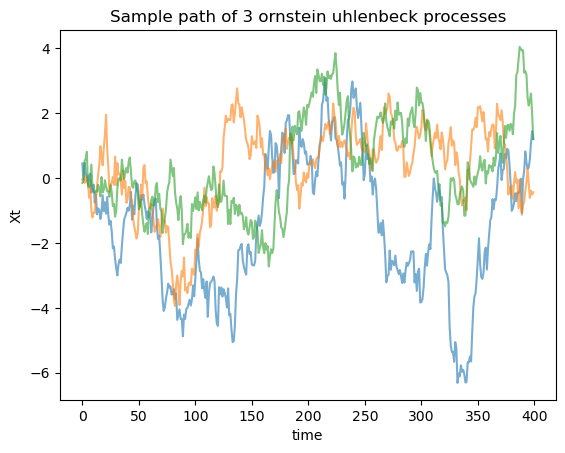

In [3]:
plt.plot(np.transpose(X[:3,:]),alpha=0.6)
plt.title('Sample path of 3 ornstein uhlenbeck processes')
plt.xlabel('time')
plt.ylabel('Xt')
plt.show()

### Part 2: stochastic control solutions applied to the monte carlo paths

#### 2.1 Exponential utility strategy & Mean variance case

In [46]:
r  = 0.02 # 0.2% interest rate
p  = np.ones((N,1)) #simplification in this model the asset prices themselves are assumed to be mean reverting
M  = 100 # amount of monte carlo simulations done
W0 = 0
gammas = [1,2,3,4]
Wealth_EU = np.zeros((M,L,len(gammas)))
Wealth_MV = np.zeros((M,L,len(gammas)))


# repeat the monte carlo simulation M times
for sim in tqdm(range(M)):
    X        = np.zeros((N,L))
    pi_EU       = np.zeros((N,L,len(gammas)))
    pi_MV       = np.zeros((N,L,len(gammas)))
    W_EU        = np.zeros((L,len(gammas)))
    W_MV        = np.zeros((L,len(gammas)))
    W_EU[:,0]   = W0
    W_MV[:,0]   = W0

    # initialise the process at t=0
    process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
    for idx in range(L):
        # perform a simulation for one time step
        X_t  = process.step().reshape((-1,1))
        t    = process.t
        X[:,idx] = X_t.reshape((1,-1))

        # calculate the change to the wealth
        if idx > 0:
            for count, gamma in enumerate(gammas):
                dW_t_EU = pi_EU[:,idx-1,count].transpose().dot(X[:,idx] - X[:,idx-1]) + (W_EU[idx-1,count] - pi_EU[:,idx-1,count].transpose() @ p)*r * delta_t
                W_EU[idx,count] = W_EU[idx-1,count] + dW_t_EU

                dW_t_MV = pi_MV[:,idx-1,count].transpose().dot(X[:,idx] - X[:,idx-1]) + (W_MV[idx-1,count] - pi_MV[:,idx-1,count].transpose() @ p)*r * delta_t
                W_MV[idx,count] = W_MV[idx-1,count] + dW_t_MV
        
        # Simulating the exponential-utility strategy
        sigma_perp_inv = inv(sigma @ sigma.transpose())
        for count, gamma in enumerate(gammas):
            pi_t_EU = sigma_perp_inv @ (theta @ (mu - X_t) - p*r) / (gamma*np.exp(r*(T-t))) + theta.transpose() @ (sigma_perp_inv) /(gamma*np.exp(r*(T-t))) @ (theta @ (mu-X_t) - p*r) * (T-t) - theta @ p *r*(T-t)**2/2
            pi_t_MV = inv(gamma*np.exp(2*r*(T-t))*sigma @ sigma.transpose()) @ (theta @ (mu - X_t) - p * r)*np.exp(r*(T-t))

            pi_EU[:,idx, count] = pi_t_EU.reshape((1,-1))
            pi_MV[:,idx, count] = pi_t_MV.reshape((1,-1))


    Wealth_EU[sim,:,:] = W_EU
    Wealth_MV[sim,:,:] = W_MV

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:36<00:00,  2.17s/it]


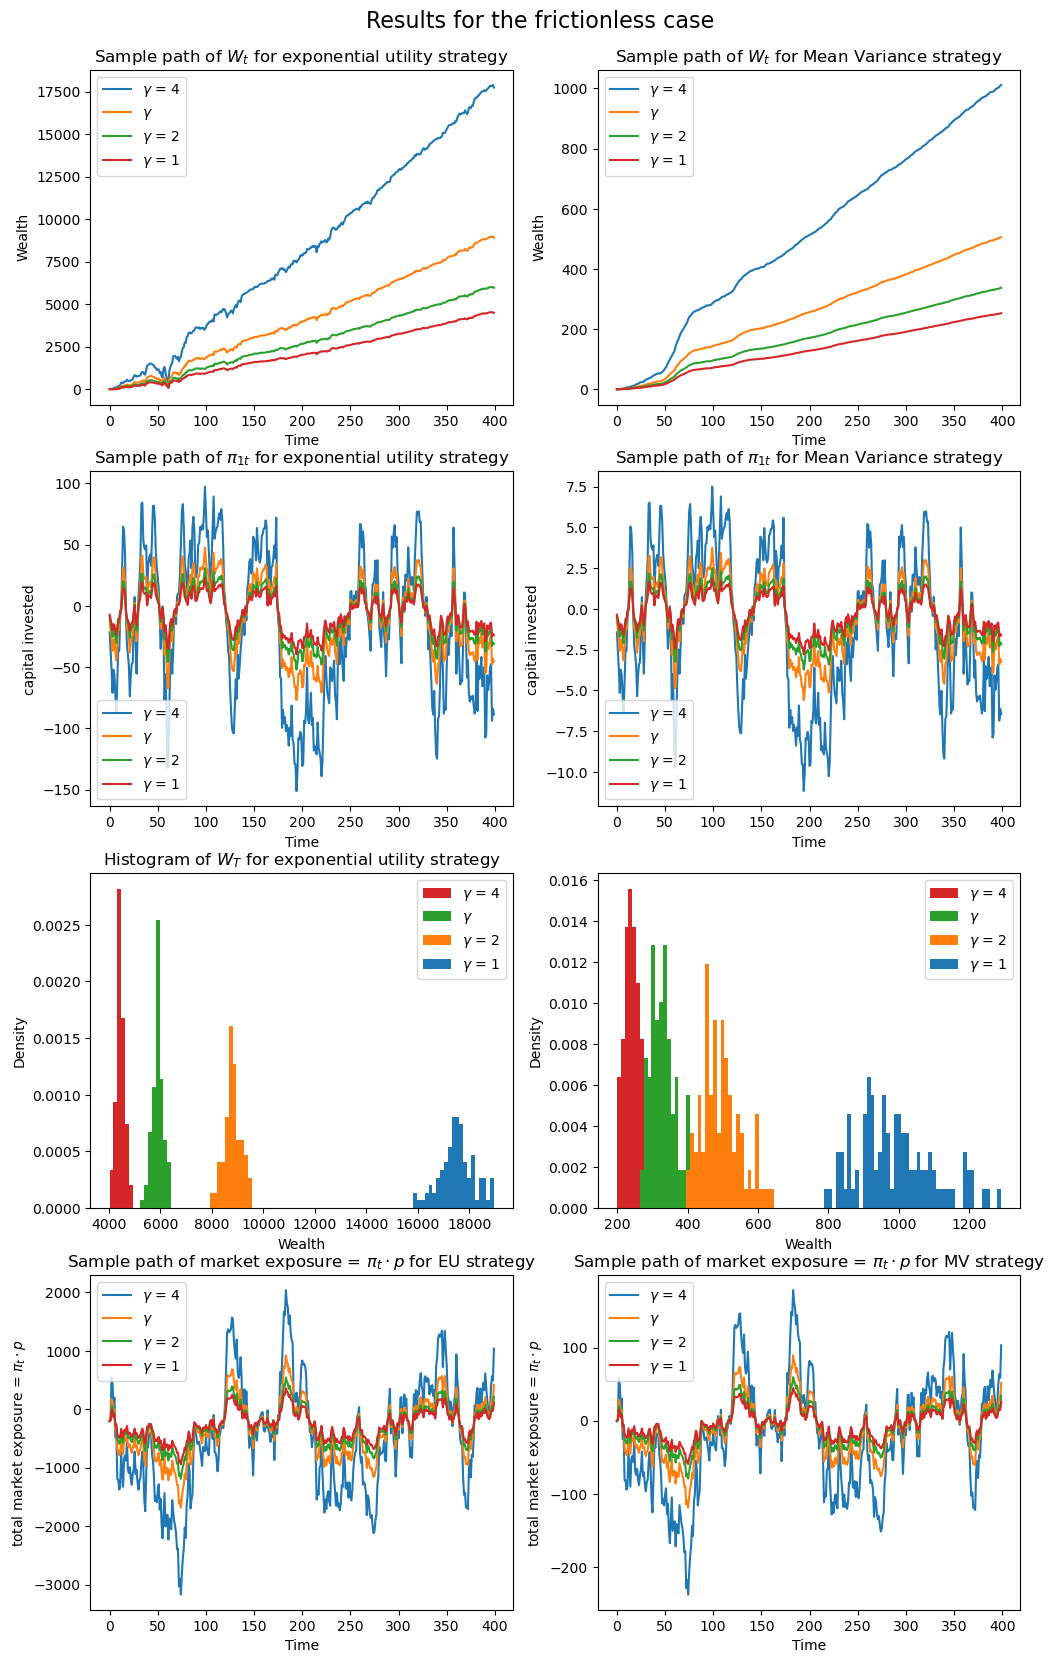

In [47]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
fig.suptitle('Results for the frictionless case', fontsize=16, y = 0.91)
# plot a sample path of the wealth
ax[0,0].plot(Wealth_EU[-1,:,:])
ax[0,0].legend([r'$\gamma$ = 4',r'$\gamma$',r'$\gamma$ = 2',r'$\gamma$ = 1'])
ax[0,0].set_title(r'Sample path of $W_t$ for exponential utility strategy')
ax[0,0].set_ylabel('Wealth')
ax[0,0].set_xlabel('Time')

ax[0,1].plot(Wealth_MV[-1,:,:])
ax[0,1].legend([r'$\gamma$ = 4',r'$\gamma$',r'$\gamma$ = 2',r'$\gamma$ = 1'])
ax[0,1].set_title(r'Sample path of $W_t$ for Mean Variance strategy')
ax[0,1].set_ylabel('Wealth')
ax[0,1].set_xlabel('Time')

# plot a sample path of the capital invested in the first asset 
ax[1,0].plot(pi_EU[0,:,:])
ax[1,0].legend([r'$\gamma$ = 4',r'$\gamma$',r'$\gamma$ = 2',r'$\gamma$ = 1'])
ax[1,0].set_title(r'Sample path of $\pi_{1t}$ for exponential utility strategy')
ax[1,0].set_ylabel('capital invested')
ax[1,0].set_xlabel('Time')

ax[1,1].plot(pi_MV[0,:,:])
ax[1,1].legend([r'$\gamma$ = 4',r'$\gamma$',r'$\gamma$ = 2',r'$\gamma$ = 1'])
ax[1,1].set_title(r'Sample path of $\pi_{1t}$ for Mean Variance strategy')
ax[1,1].set_ylabel('capital invested')
ax[1,1].set_xlabel('Time')


# plot the density
ax[2,0].hist(Wealth_EU[:,-1,:],bins=100, density=True,histtype='stepfilled')
ax[2,0].legend([r'$\gamma$ = 4',r'$\gamma$',r'$\gamma$ = 2',r'$\gamma$ = 1'])
ax[2,0].set_title(r'Histogram of $W_T$ for exponential utility strategy')
ax[2,0].set_xlabel('Wealth')
ax[2,0].set_ylabel('Density')

ax[2,1].hist(Wealth_MV[:,-1,:],bins=100, density=True,histtype='stepfilled')
ax[2,1].legend([r'$\gamma$ = 4',r'$\gamma$',r'$\gamma$ = 2',r'$\gamma$ = 1'])
ax[2,1].set_title(r'Histogram of $W_T$ for Mean Variance strategy')
ax[2,1].set_xlabel('Wealth')
ax[2,1].set_ylabel('Density')

# plot the total market allocation
ax[3,0].plot(pi_EU.sum(axis=0))
ax[3,0].legend([r'$\gamma$ = 4',r'$\gamma$',r'$\gamma$ = 2',r'$\gamma$ = 1'])
ax[3,0].set_title(r'Sample path of market exposure = $\pi_t \cdot p$ for EU strategy')
ax[3,0].set_xlabel('Time')
ax[3,0].set_ylabel(r'total market exposure = $\pi_t \cdot p$ ')

ax[3,1].plot(pi_MV.sum(axis=0))
ax[3,1].legend([r'$\gamma$ = 4',r'$\gamma$',r'$\gamma$ = 2',r'$\gamma$ = 1'])
ax[3,1].set_title(r'Sample path of market exposure = $\pi_t \cdot p$ for MV strategy')
ax[3,1].set_xlabel('Time')
ax[3,1].set_ylabel(r'total market exposure = $\pi_t \cdot p$ ')

plt.show()

#### 2.2 Imposing dollar neutrality

In [48]:
r  = 0.02 # 0.2% interest rate
p  = np.ones((N,1)) #simplification in this model the asset prices themselves are assumed to be mean reverting
M  = 100 # amount of monte carlo simulations done
W0 = 0
gammas = [1,2,3,4]
alpha  = 100 # market neutrality penalty
Wealth_EU = np.zeros((M,L,len(gammas)))
Wealth_MV = np.zeros((M,L,len(gammas)))

# I need to solve a ricatti matrix ODE, and a linear system of ODE's for use later on
C = np.zeros((N,N,L,len(gammas)))
b = np.zeros((N,L,len(gammas)))
for count, gamma in enumerate(gammas):
    # first Ricatti ODE
    def odefunc1(c, u): # u = T-t
        n     = int(np.sqrt(len(c)))
        c     = c.reshape([n,n])
        sigma_sigma_transpose = sigma @ sigma.transpose()
        dc_du = theta.transpose() @ c + c @ theta + gamma * c @ sigma_sigma_transpose @ c - np.exp(r*u) \
            * (theta + gamma * sigma_sigma_transpose).transpose() @ inv(gamma* sigma_sigma_transpose + np.exp(r*u) + alpha * p @ p.transpose()) \
            @ (theta + gamma * sigma_sigma_transpose @ c)
        return dc_du.reshape(-1)
    sol = odeint(odefunc1, np.linspace(0,T,L),np.zeros(N*N))
    C[:,:,:,count] = sol.reshape((100,100,400)) # Remember the values need to be accessed in reverse order on the time axis!!
    
    # second linear system of ODE's
    def odefunc2(b, u):
        db_du = theta.transpose() @ b - C[:,:,u,count] @ theta @ mu - np.exp(r*u) * \
            (theta + gamma * sigma @ sigma.transpose() @ C[:,:,u,count]) @ \
                inv(gamma * sigma @ sigma.transpose()*np.exp(r*u) + alpha * p @ p.transpose()) @ \
                (theta @ mu - p * r - gamma * sigma @ sigma.transpose() @ C[:,:,u,count])
        return db_du
    sol = odeint(odefunc2,np.linspace(0,T,L),np.zeros(N))
    b[:,:,count] = sol
    


# repeat the monte carlo simulation M times
for sim in tqdm(range(M)):
    X        = np.zeros((N,L))
    pi_EU       = np.zeros((N,L,len(gammas)))
    pi_MV       = np.zeros((N,L,len(gammas)))
    W_EU        = np.zeros((L,len(gammas)))
    W_MV        = np.zeros((L,len(gammas)))
    W_EU[:,0]   = W0
    W_MV[:,0]   = W0

    # initialise the process at t=0
    process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
    for idx in range(L):
        # perform a simulation for one time step
        X_t  = process.step().reshape((-1,1))
        t    = process.t
        X[:,idx] = X_t.reshape((1,-1))

        # calculate the change to the wealth
        if idx > 0:
            for count, gamma in enumerate(gammas):
                dW_t_EU = pi_EU[:,idx-1,count].transpose().dot(X[:,idx] - X[:,idx-1]) + (W_EU[idx-1,count] - pi_EU[:,idx-1,count].transpose() @ p)*r * delta_t
                W_EU[idx,count] = W_EU[idx-1,count] + dW_t_EU

                dW_t_MV = pi_MV[:,idx-1,count].transpose().dot(X[:,idx] - X[:,idx-1]) + (W_MV[idx-1,count] - pi_MV[:,idx-1,count].transpose() @ p)*r * delta_t
                W_MV[idx,count] = W_MV[idx-1,count] + dW_t_MV
        
        # Simulating the exponential-utility and mean variance strategy
        sigma_perp_inv = inv(sigma @ sigma.transpose())
        for count, gamma in enumerate(gammas):
            pi_t_MV = inv(gamma * np.exp(r*(T-t)) * sigma @ sigma.transpose() + alpha * p @ p.transpose()) @ \
                (theta @ (mu - X_t) - p*r)*np.exp(r*(T-t))
            pi_t_EU = inv(gamma*np.exp(r*(T-t))*sigma @ sigma.transpose() + alpha * p @ p.transpose()) @ \
                (theta @ (mu - X_t) - p * r - gamma * sigma @ sigma.transpose() @ (b[:,-idx-1,count].reshape((-1,1)) + C[:,:,-idx-1,count] @ X_t))

            pi_EU[:,idx, count] = pi_t_EU.reshape((1,-1))
            pi_MV[:,idx, count] = pi_t_MV.reshape((1,-1))


    Wealth_EU[sim,:,:] = W_EU
    Wealth_MV[sim,:,:] = W_MV

100%|██████████| 100/100 [04:19<00:00,  2.59s/it]


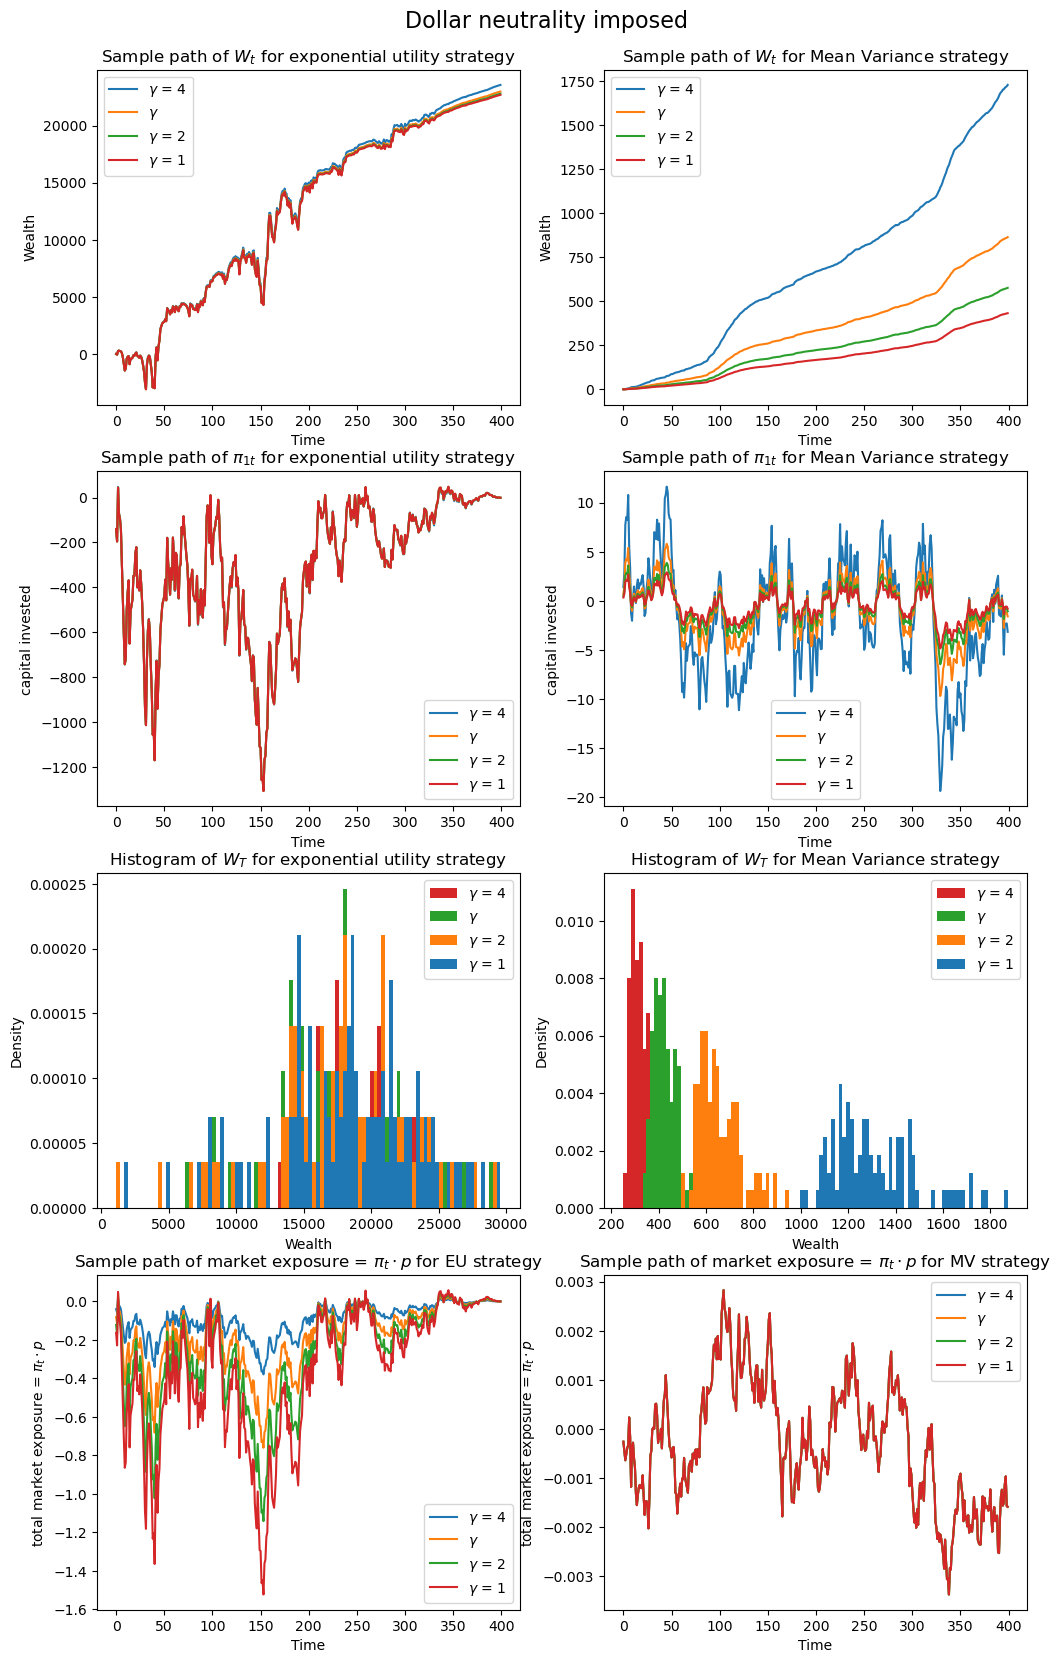

In [50]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
fig.suptitle('Dollar neutrality imposed', fontsize=16, y = 0.91)
# plot a sample path of the wealth
ax[0,0].plot(Wealth_EU[-1,:,:])
ax[0,0].legend([r'$\gamma$ = 4',r'$\gamma$',r'$\gamma$ = 2',r'$\gamma$ = 1'])
ax[0,0].set_title(r'Sample path of $W_t$ for exponential utility strategy')
ax[0,0].set_ylabel('Wealth')
ax[0,0].set_xlabel('Time')

ax[0,1].plot(Wealth_MV[-1,:,:])
ax[0,1].legend([r'$\gamma$ = 4',r'$\gamma$',r'$\gamma$ = 2',r'$\gamma$ = 1'])
ax[0,1].set_title(r'Sample path of $W_t$ for Mean Variance strategy')
ax[0,1].set_ylabel('Wealth')
ax[0,1].set_xlabel('Time')

# plot a sample path of the capital invested in the first asset 
ax[1,0].plot(pi_EU[0,:,:])
ax[1,0].legend([r'$\gamma$ = 4',r'$\gamma$',r'$\gamma$ = 2',r'$\gamma$ = 1'])
ax[1,0].set_title(r'Sample path of $\pi_{1t}$ for exponential utility strategy')
ax[1,0].set_ylabel('capital invested')
ax[1,0].set_xlabel('Time')

ax[1,1].plot(pi_MV[0,:,:])
ax[1,1].legend([r'$\gamma$ = 4',r'$\gamma$',r'$\gamma$ = 2',r'$\gamma$ = 1'])
ax[1,1].set_title(r'Sample path of $\pi_{1t}$ for Mean Variance strategy')
ax[1,1].set_ylabel('capital invested')
ax[1,1].set_xlabel('Time')


# plot the density
ax[2,0].hist(Wealth_EU[:,-1,:],bins=100, density=True,histtype='stepfilled')
ax[2,0].legend([r'$\gamma$ = 4',r'$\gamma$',r'$\gamma$ = 2',r'$\gamma$ = 1'])
ax[2,0].set_title(r'Histogram of $W_T$ for exponential utility strategy')
ax[2,0].set_xlabel('Wealth')
ax[2,0].set_ylabel('Density')

ax[2,1].hist(Wealth_MV[:,-1,:],bins=100, density=True,histtype='stepfilled')
ax[2,1].legend([r'$\gamma$ = 4',r'$\gamma$',r'$\gamma$ = 2',r'$\gamma$ = 1'])
ax[2,1].set_title(r'Histogram of $W_T$ for Mean Variance strategy')
ax[2,1].set_xlabel('Wealth')
ax[2,1].set_ylabel('Density')

# plot the total market allocation
ax[3,0].plot(pi_EU.sum(axis=0))
ax[3,0].legend([r'$\gamma$ = 4',r'$\gamma$',r'$\gamma$ = 2',r'$\gamma$ = 1'])
ax[3,0].set_title(r'Sample path of market exposure = $\pi_t \cdot p$ for EU strategy')
ax[3,0].set_xlabel('Time')
ax[3,0].set_ylabel(r'total market exposure = $\pi_t \cdot p$ ')

ax[3,1].plot(pi_MV.sum(axis=0))
ax[3,1].legend([r'$\gamma$ = 4',r'$\gamma$',r'$\gamma$ = 2',r'$\gamma$ = 1'])
ax[3,1].set_title(r'Sample path of market exposure = $\pi_t \cdot p$ for MV strategy')
ax[3,1].set_xlabel('Time')
ax[3,1].set_ylabel(r'total market exposure = $\pi_t \cdot p$ ')

plt.show()

#### 2.3 Quadratic transaction costs

### Part 3: Deep reinforcement learning applied to the monte carlo paths

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym
from IPython.display import clear_output

In [ ]:
# Before starting the environment needs to be made

class TradingEnvironment():
    def __init__(self, process):
        process.reset()
        

    def reset(self):
        None

    def step(self):

        return state, reward, done, _

#### 3.1 Advantage Actor-Critic learning (A2C) (single worker)

First the policy and value models need to be created 

In [68]:
class PolicyModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.3):
        """
        This is a basic Artificial Neural Network that can be used for both the Actor and the Critic.
        Parameters
        ----------
        input_dim: int
        hidden_dim: int
        output_dim: int
        dropout: float
        
        Returns
        -------
        """
        super().__init__()

        self.fc_1 = nn.Linear(input_dim,hidden_dim) 
        self.fc_2 = nn.Linear(hidden_dim,hidden_dim)

        self.fc_mu = nn.Linear(hidden_dim,output_dim)
        self.fc_sigma = nn.Linear(hidden_dim,output_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        Prediction of the Neural Network given an input x (in RL, x is a state).
        The Network uses a dropout layer (to help generalize), and the ReLU activation function.
        Parameters
        ----------
        x: tensor
            input, i.e. state
        
        Returns
        -------
        x: tensor
            the network's prediction (output) for this input.
        """
        # first two hidden layers are shared for mu and sigma
        x = F.relu(self.dropout(self.fc_1(x)))
        x = F.relu(self.dropout(self.fc_2(x)))

        mu = self.fc_mu(x)   # final layer estimates mu
        sigma = self.relu(x) # final layer estimates sigma
        return mu, sigma

class ValueModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.3):
        """
        This is a basic Artificial Neural Network that can be used for both the Actor and the Critic.
        Parameters
        ----------
        input_dim: int
        hidden_dim: int
        output_dim: int
        dropout: float
        
        Returns
        -------
        """
        super().__init__()

        self.fc_1 = nn.Linear(input_dim,hidden_dim) 
        self.fc_2 = nn.Linear(hidden_dim,hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim,output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        Prediction of the Neural Network given an input x (in RL, x is a state).
        The Network uses a dropout layer (to help generalize), and the ReLU activation function.
        Parameters
        ----------
        x: tensor
            input, i.e. state
        
        Returns
        -------
        x: tensor
            the network's prediction (output) for this input.
        """
        x = F.relu(self.dropout(self.fc_1(x)))
        x = F.relu(self.dropout(self.fc_2(x)))
        x = self.fc_3(x)
        return x

class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        """
        This is a joint model, with two ANNs within.
        Parameters
        ----------
        actor: BaseModel instance
        
        critic: BaseModel instance
        """
        super().__init__()
        
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        """ 
        The output of the ActorCritic model is the concatenation of the actor and critic's outputs.
        Since the actor is a policy, we convert the output into probabilities using a softmax function.
        Parameters
        ----------
        state: tensor
            model input, i.e. state the agent is in
        
        Returns
        -------
        action_pred, value_pred: tensor, tensor
            the network's prediction (output) for this input.
        """

        action_mu_pred, action_sigma_pred = self.actor(state)
        value_pred   = self.critic(state)
        
        return action_mu_pred, action_sigma_pred, value_pred

In [ ]:
def calculate_returns(rewards, values, discount_factor, normalize = False):
    """
    Function to calculate rewards in time step order and normalize them.
    Normalizing stabilizes the results.
    Parameters
    ----------
    rewards: list of floats
    
    discount_factor: float
    
    Returns
    -------
    returns: tensor
        tensor of returns G_t in time-step order
    """
    # TODO: calculate future rewards
    returns = np.zeros(len(rewards))
    rewards = rewards + [0,0,0]
    vals    = list(values.detach().numpy()) + [0,0,0]
    for i in range(len(returns)):
        # TODO: Calculate n step return :
        #val = values[i+3] if i+4 <= len(returns) else 0
        returns[i] = rewards[i] + discount_factor * rewards[i+1] + discount_factor**2 * rewards[i+2] \
            + discount_factor**3 * vals[i+3]

    if normalize:
        
        returns = (returns - returns.mean()) / returns.std()
        
    return torch.tensor(returns)

def calculate_advantages(returns, values, normalize = False):
    """
    Computes the advantage for all actions. 
    Reminder: the Advantage function for an action a is A(s,a) = Q(s,a) - V(s)
    Normalizing stabilizes the results.
    Parameters
    ----------
    returns: tensor
        Returns G_t during an episode
    
    values: tensor
        Value estimates V(s_t)
    
    Returns
    -------
    advantages: tensor
    """
    # TODO: calculate advantage
    advantages = returns - values
    
    # TODO: write code to normalize the values
    if normalize:
        advantages = (advantages - advantages.mean()) / advantages.std()

    return advantages

def update_policy(advantages, log_prob_actions, returns, values):
    """
    Function to update your policy based on your actor and critic loss.
    
    Parameters
    ----------
    advantages: tensor
    log_prob_actions: tensor
    returns: tensor
    values: tensor
    optimizer: adam instance

    Returns
    -------

    """
    
    advantages = advantages.detach()
    returns = returns.detach()
    
    #calculate policy loss based on advantages and log_prob_actions.
    policy_loss = -(log_prob_actions * advantages).sum()
    
    # calculate value loss based on Mean Absolute Error
    value_loss = ((returns-values)**2).mean()
        
    return policy_loss, value_loss

def train(env, agent, optimizer, discount_factor):
    """
    Performs a single training step over an episode.

    Parameters
    ----------
    agent: ActorCritic
    optimizer: PyTorch optimizer
    discount_factor: float
        discount gamma
    
    Returns
    -------
    policy_loss: float 
        loss of the policy (actor)
    value_loss: float
        loss of the value function approximator (critic)
    episode_reward: float
        reward for this episode
    """
    agent.train()
    
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)
        
        action_mu, action_sigma, value_pred = agent.forward(state)
        
        dist   = distributions.Normal(action_mu, action_sigma)
        action = dist.sample()
        log_prob_action = dist.log_prob(action) # not sure if this is correct for the normal distribution
        
        state, reward, done, _ = env.step(action.item())
        
        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)

        episode_reward += reward
    
    log_prob_actions = torch.cat(log_prob_actions)
    print('log prob: {}'.format(log_prob_actions))

    values = torch.cat(values).squeeze(-1)
    
    returns = calculate_returns(rewards, values, discount_factor)
    print('returns: {}'.format(returns))

    advantages = calculate_advantages(returns, values)
    print('adv: {}'.format(advantages))

    policy_loss, value_loss = update_policy(advantages, log_prob_actions, returns, values)

    optimizer.zero_grad()
    
    policy_loss.backward()
    value_loss.backward()
    
    optimizer.step()

    return policy_loss.item(), value_loss.item(), episode_reward

In [ ]:
def evaluate(env, agent, vis=False):
    """
    Function to evaluate your agent's performance.
    """
    agent.eval()
    
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()
    if vis: env.render()
    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
            action,_, _ = agent.forward(state) #TODO: Not sure if only Mu is used when performing eval

        state, reward, done, _ = env.step(action.item())

        episode_reward += reward
        
    return episode_reward

In [ ]:
def plot(frame_idx, train_rewards, policy_loss, value_loss):
    """
    Plots the running reward and losses.
    Parameters
    ----------
    frame_idx: int
        frame id
    rewards: int
        accumulated reward
    losses: int
        loss
    """
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (frame_idx, np.mean(train_rewards[-10:])))
    plt.plot(train_rewards)
    plt.subplot(132)
    plt.title('policy loss')
    plt.plot(policy_loss)
    plt.subplot(133)
    plt.title('value loss')
    plt.plot(value_loss)
    plt.show()

In [69]:
MAX_EPISODES = 1000
LEARNING_RATE = 0.0025
MAX_EPISODES = 5000
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 195

INPUT_DIM  = 2 * N # first N input values is X_t and the next is pi_t
HIDDEN_DIM = 128
OUTPUT_DIM_ACTOR = N
OUTPUT_DIM_CRITIC = 1

policy_losses = []
value_losses = []
train_rewards = []
test_rewards = []

# init agent
actor = PolicyModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_ACTOR)
critic = ValueModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_CRITIC)
agent = ActorCritic(actor, critic)

def init_weights(m):
    """ Initializes the ANNs weights with a relevant distribution. """
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

agent.apply(init_weights)
optimizer = optim.Adam(agent.parameters(), lr = LEARNING_RATE)

In [70]:
agent

ActorCritic(
  (actor): PolicyModel(
    (fc_1): Linear(in_features=200, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=128, bias=True)
    (fc_mu): Linear(in_features=128, out_features=100, bias=True)
    (fc_sigma): Linear(in_features=128, out_features=100, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (critic): ValueModel(
    (fc_1): Linear(in_features=200, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=128, bias=True)
    (fc_3): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

In [ ]:
for episode in range(1, MAX_EPISODES+1):
    policy_loss, value_loss, train_reward = train(train_env, agent, optimizer, DISCOUNT_FACTOR)
    test_reward = evaluate(eval_env, agent, False)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    plot(episode, train_rewards, policy_losses, value_losses)

    if mean_test_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        
        break

#### 3.2 Proximal Policy Optimisation (PPO)